![logo](JFM-notebooks-logo.jpg)

# Spectral analysis of the laminar flow and the lower branch traveling wave

In this notebook we present calculations related to the spectrum of the two fixed point solutions, the lower branch traveling wave and the laminar flow. 
The eigenvalues are obtained using the Newton-Krylov algorithm built into ```Openpipeflow``` (developed by Ashley Willis, https://openpipeflow.org/).

- We show the leading eigenvalues of the lower branch traveling wave and check that the nonresonance conditions required by results of Haller et al. 2023 hold.

- We show the calculations necessary to explicitly compute the analytic (primary) slow SSM of the laminar flow

## Check for resonances in the spectrum of the lower branch traveling wave

In [1]:
import numpy as np

In [2]:
eig2LB = np.loadtxt('data/arnoldi.dat', skiprows = 3)

The existence results for the mixed-mode SSM apply if Sternberg's linearization theorem applies. 
Let us denote the eigenvalues as $\lambda_i$ and ordering them according to descending real part. We then require that there is no resonance among eigenvalues, i.e

$$
\lambda_j \neq \sum_{i} m_i \lambda_i \quad \sum_i m_i \geq 2
$$

We select the leading $15$ eigenvalues, but this corresponds to $24$ eigenvalues in total, due to the complex-conjugate pairs. 

In [3]:
ms = np.arange(0, 5, 1)

In [4]:
eigenvalues = eig2LB[np.abs(eig2LB[:,1])>0.001, 1] + 1j*eig2LB[np.abs(eig2LB[:,1])>0.001,2]

In [5]:
eigenvalues = np.unique(np.concatenate((eigenvalues, np.conjugate(eigenvalues))))

In [6]:
sort_ind = np.argsort(-np.real(eigenvalues), axis=0)

In [8]:
eigenvalues = np.take_along_axis(eigenvalues, sort_ind, axis = 0)

In [9]:
from sklearn.preprocessing import PolynomialFeatures

In [10]:
polyfeat = PolynomialFeatures(degree = 6)


In [11]:
polyfeat.fit(np.ones(eigenvalues.shape).reshape(1,-1)) # we use PolynomialFeatures to get all linear combinations

PolynomialFeatures(degree=6)

We create an array that enumerates all possible integer linear combinations of the eigenvalues up to order 5. 

In [12]:
poww = polyfeat.powers_

In [13]:
poww.shape

(593775, 24)

In [142]:
lincombs = []

In [143]:
for i in range(poww.shape[0]):
    if np.sum(poww[i,:]>1):
        summ = 0.
        for j in range(poww.shape[1]):
            summ = summ + poww[i,j]*eigenvalues[j]
        lincombs.append(summ)
    else:
        lincombs.append(1e10)

From the linear combinations $\sum_{i} m_i \lambda_i $ we select the one that is closest to every eigenvalue, that is we take 

$$
D(\lambda_j) = \text{min}_m |\lambda_j - \sum_{i} m_i \lambda_i |
$$

In [145]:
mindist = []
minlincomb = []
for i in range(len(eigenvalues)):
    distances = []
    for j in range(len(lincombs)):
        distances.append(np.abs(eigenvalues[i] - lincombs[j]))
    amax = np.argmin(distances)
    mindist.append(distances[amax])
    minlincomb.append(poww[amax,:])

We then compute a relative metric of resonance-nearness,
$$
\frac{D(\lambda_j)}{|\lambda_j|}
$$

In [146]:
relative_dist = mindist/np.abs(eigenvalues)

The eigenvalue closest to resonance is



In [147]:
closest_index = np.argmin(relative_dist)

In [153]:
closest_index

20

In [315]:
relative_dist[closest_index]

0.0024162315256366787

The closest near-resonance observed is at 


In [16]:
from sympy import latex
from IPython.display import display_latex



def disp(idx, symObj):
    eqn = '$' + idx + ' ' + latex(symObj) + '$'
    display_latex(eqn,raw=True)
    return

In [166]:
disp('\lambda_{20}=', eigenvalues[closest_index])


and the closest linear combination is



In [171]:
disp('\lambda_{1} + \lambda_{4} + 3 \lambda_{8}=', eigenvalues[0] + eigenvalues[3] + 3*eigenvalues[7])

In [158]:
eigenvalues[(minlincomb[closest_index])>0]

array([ 0.01976398-0.j        , -0.01511716+0.00822741j,
       -0.02326274-0.j        ])

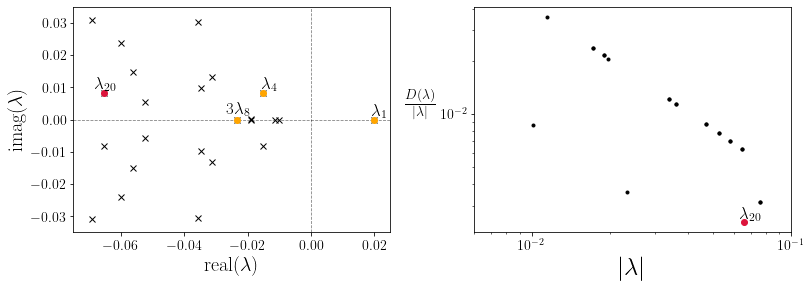

In [316]:
f = plt.figure()
import matplotlib
ratio = 8/5
ax = f.add_subplot(122)
ax2 = f.add_subplot(121)

f.set_size_inches(3.38*2*1.7, (3.38*2)/ratio, forward=True)
ax.loglog(np.abs(eigenvalues), mindist/np.abs(eigenvalues), '.', c='black')
ax.text(.96*np.abs(eigenvalues)[20], 1.05*(mindist/np.abs(eigenvalues))[20], '$\\lambda_{20}$', fontsize = 17)
ax.loglog(np.abs(eigenvalues)[20], (mindist/np.abs(eigenvalues))[20], 'o', c='crimson')

ax.set_xlabel(r'$|\lambda|$', fontsize = 25)
ax.set_ylabel(r'$\frac{D(\lambda)}{|\lambda|}$', rotation=0, labelpad = 20, fontsize = 20)
ax2.plot([-0.075, 0.025], [0,0], '--', c='black', alpha = 0.5, linewidth =0.8)
ax2.plot([0, 0.0], [-0.035,0.035], '--', c='black', alpha = 0.5, linewidth =0.8)

ax2.plot(np.real(eigenvalues), np.imag(eigenvalues), 'x', c='black')
ax2.plot(np.real(eigenvalues)[20], np.imag(eigenvalues)[20], 'o', c='crimson')
ax2.text(1.05*np.real(eigenvalues)[20], 1.18*np.imag(eigenvalues)[20], '$\\lambda_{20}$', fontsize = 17)

ax2.plot(np.real(eigenvalues)[0], np.imag(eigenvalues)[0], 'o', c='orange')
ax2.text(.95*np.real(eigenvalues)[0], 0.0015 + np.imag(eigenvalues)[0], '$\\lambda_{1}$', fontsize = 17)

ax2.plot(np.real(eigenvalues)[3], np.imag(eigenvalues)[3], 'o', c='orange')
ax2.text(1.05*np.real(eigenvalues)[3], 1.18*np.imag(eigenvalues)[3], '$\\lambda_{4}$', fontsize = 17)


ax2.plot(np.real(eigenvalues)[7], np.imag(eigenvalues)[7], 'o', c='orange')
ax2.text(1.15*np.real(eigenvalues)[7], 0.0019+np.imag(eigenvalues)[7], '$3\\lambda_{8}$', fontsize = 17)


ax2.set_xlim(-0.075, 0.025)
ax2.set_ylim(-0.035, 0.035)

ax2.set_xlabel(r'real$(\lambda)$', fontsize = 20)
ax2.set_ylabel(r'imag$(\lambda)$', fontsize = 20)

from matplotlib import ticker

ax.set_xlim(0.006, 0.1)
#ax.set_ylim(0.005, 0.06)
f.tight_layout()


## Calculating the spectrum of the laminar flow

In [3]:
import sympy as sy

In [4]:
from sympy.vector import CoordSys3D, Del
from sympy.vector import divergence, gradient, curl, matrix_to_vector, dot, cross


In [5]:
r, phi, z, t = sy.symbols('r \\varphi z t')
ur = sy.Function('u_r')(r, phi, z, t)
uphi = sy.Function('u_\\varphi')(r, phi, z, t)
uz = sy.Function('u_z')(r, phi, z, t)
p = sy.Function('p')(r, phi, z, t)
nu = sy.symbols('\\nu')

In [6]:
R = CoordSys3D('R', transformation='cylindrical', variable_names=("r", "phi", "z"))
to_cyl_sub = {r:R.r, phi:R.phi, z:R.z}
from_cyl_sub = {R.r:r, R.phi:phi, R.z:z}

In [7]:
u = ur.subs(to_cyl_sub)*R.i + uphi.subs(to_cyl_sub)*R.j + uz.subs(to_cyl_sub)*R.k

In [8]:
umatrix = u.to_matrix(R).subs(from_cyl_sub)

In [9]:
laplacian = sy.simplify(curl(curl(u)) - gradient(divergence(u))).to_matrix(R).subs(from_cyl_sub)

In [10]:
ugradu = sy.simplify((gradient(dot(u,u)) - 2* cross(u, curl(u)))/2).to_matrix(R)

In [11]:
gradp = gradient(p.subs(to_cyl_sub)).to_matrix(R).subs(from_cyl_sub)

In [12]:
nonlinearity = ugradu.subs(from_cyl_sub)

In [13]:
navierstokes = umatrix.diff(t) + ugradu.subs(from_cyl_sub) + gradp - nu * laplacian

In [14]:
from sympy import latex
from IPython.display import display_latex



def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

In [17]:
disp('\\mathcal{N}(\mathbf{u})=',navierstokes)

In [18]:
uhp = sy.Matrix([0,0,1-r**2])

## We now linearize around the parabolic profile
$$
\mathbf{u}_{HP} = \begin{pmatrix}0 \\ 0 \\ 1-r^2 \end{pmatrix}
$$

In [19]:
epsilon = sy.symbols('\\varepsilon')


In [20]:
Linearized_Ns = navierstokes.subs([(ur, epsilon*ur),
                                   (uphi, epsilon*uphi),
                                   (uz, 1-r**2 + epsilon * uz),
                                   (p, 4*nu*z + epsilon*p)])


In [21]:
Linearized_Ns = Linearized_Ns.diff(epsilon).subs(epsilon, 0).doit()

In [22]:
disp('D\mathcal{N}(\mathbf{u}_{HP})=',Linearized_Ns)

In [23]:
k, m= sy.symbols('k m', integers=True)

In [24]:
alpha = sy.symbols('\\alpha')
lamb = sy.symbols('\\lambda')

In [25]:
ii = sy.sqrt(-1)

In [26]:
ar = sy.Function('a_r')(r)
aphi = sy.Function('a_\\varphi')(r)
az = sy.Function('a_z')(r)
ap = sy.Function('a_p')(r)



This operator can be decomposed to normal modes of the form 

$$
\mathbf{u} = ae^{ik\alpha z} e^{ikm\varphi} e^{\lambda t}
$$

We expect that the least stable mode is obtained with $m=0$, in which case the equation simplifies to the eigenvalue equation

In [27]:
Normalmode_ns = Linearized_Ns.subs([(ur, ar*sy.exp(ii*m*phi + ii*k*alpha*z)*sy.exp(lamb*t)),
                   (uphi,aphi*sy.exp(ii*m*phi + ii*k*alpha*z)*sy.exp(lamb*t)),
                   (uz,az*sy.exp(ii*m*phi + ii*k*alpha*z)*sy.exp(lamb*t)),
                   (p, ap*sy.exp(ii*m*phi + ii*k*alpha*z)*sy.exp(lamb*t))]).doit()

In [28]:
Normalmode_ns = sy.simplify(Normalmode_ns/(sy.exp(ii*m*phi + ii*k*alpha*z)*sy.exp(lamb*t)))

In [29]:
equation = sy.Matrix([eq for eq in Normalmode_ns])

In [30]:
simplified_eq = equation.subs(k, 0).subs(ar,0).subs(aphi, 0).subs(ap,0).doit()

In [31]:
disp('0=',simplified_eq[2])
